# Segmentation: K-means

In [ ]:
import numpy as np
import pandas as pd
import torch

# Visualization
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

# Feature Engineering
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, label_binarize, LabelEncoder

# Machine Learning
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Grid Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, roc_auc_score, classification_report

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
from sklearn.cluster import KMeans

columns = [line.strip() for line in open('census-bureau.columns')]

df = pd.read_csv('census-bureau.data', header=None, names=columns, na_values='?')
# change label to 0/1
df['label'] = df['label'].str.strip()
df['label'] = df['label'].apply(lambda x: 1 if x == '50000+.' else 0)

# replace placeholder with NA
df.replace(['?'], pd.NA, inplace=True)

# Drop columns with too many missing values
missing_ratio = df.isna().mean()
df = df.drop(columns=missing_ratio[missing_ratio > 0.4].index)

# Fill NaN in categorical with "Unknown", numerical with median
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna("Unknown")
    else:
        df[col] = df[col].fillna(df[col].median())
# get categorical columns
categorical_cols = [
    'class of worker', 'detailed industry recode', 'detailed occupation recode',
    'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code',
    'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union',
    'reason for unemployment', 'full or part time employment stat', 'tax filer stat',
    'region of previous residence', 'state of previous residence',
    'detailed household and family stat', 'detailed household summary in household',
    'live in this house 1 year ago',
    'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self',
    'citizenship', 'own business or self employed', 'fill inc questionnaire for veteran\'s admin',
    'veterans benefits'
]

# one-hot encoding categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, dummy_na=True)



In [ ]:
from sklearn.preprocessing import StandardScaler

X_cluster = df_encoded.drop(['label', 'weight'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

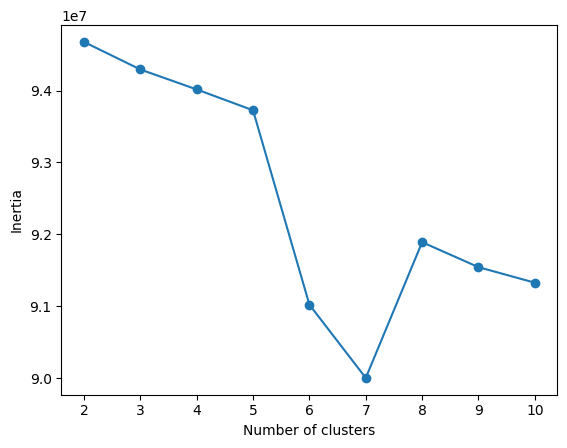

In [ ]:
# Elbow method to choose k
inertia = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Choose k=7
kmeans = KMeans(n_clusters=7, random_state=42)
df_encoded['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
# Label distribution in each group
cluster_summary = df_encoded.groupby('cluster')[['label']].mean()
print(cluster_summary)

            label
cluster          
0        0.000000
1        0.048561
2        0.008855
3        0.009626
4        0.094595
5        0.054497
6        0.120718


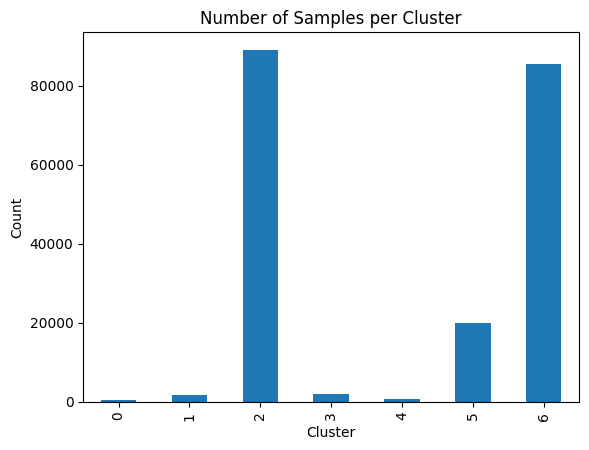

In [ ]:
# Number of samples per cluster
df['cluster'] = kmeans.fit_predict(X_scaled)
df['cluster'].value_counts().sort_index().plot(kind='bar')
plt.title("Number of Samples per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

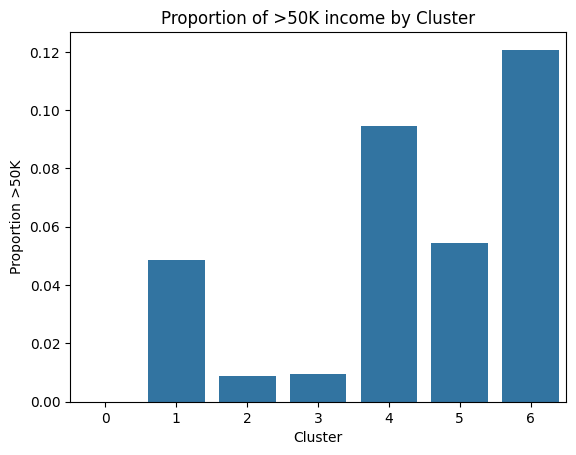

In [ ]:
cluster_label_dist = df.groupby('cluster')['label'].mean()
sns.barplot(x=cluster_label_dist.index, y=cluster_label_dist.values)
plt.title("Proportion of >50K income by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion >50K")
plt.show()

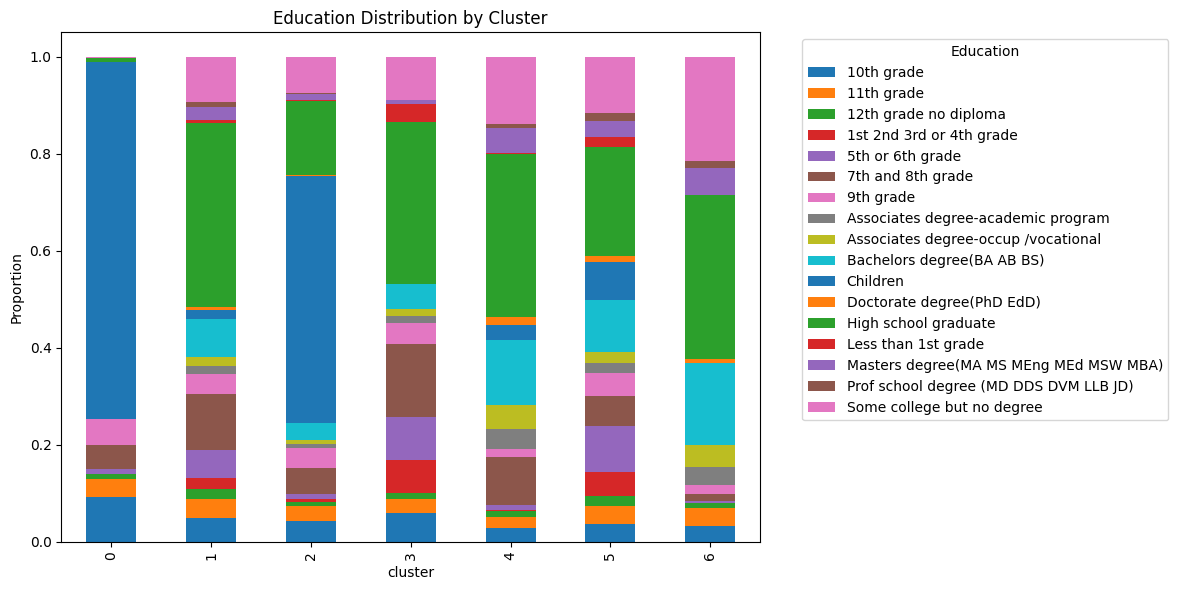

In [ ]:
# Education distribution
edu_dist = pd.crosstab(df['cluster'], df['education'])
edu_dist.div(edu_dist.sum(1), axis=0).plot(kind="bar", stacked=True, figsize=(12,6))

plt.title("Education Distribution by Cluster")
plt.ylabel("Proportion")

# Move legend outside the plot
plt.legend(title='Education', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # adjust layout so nothing is cut off
plt.show()

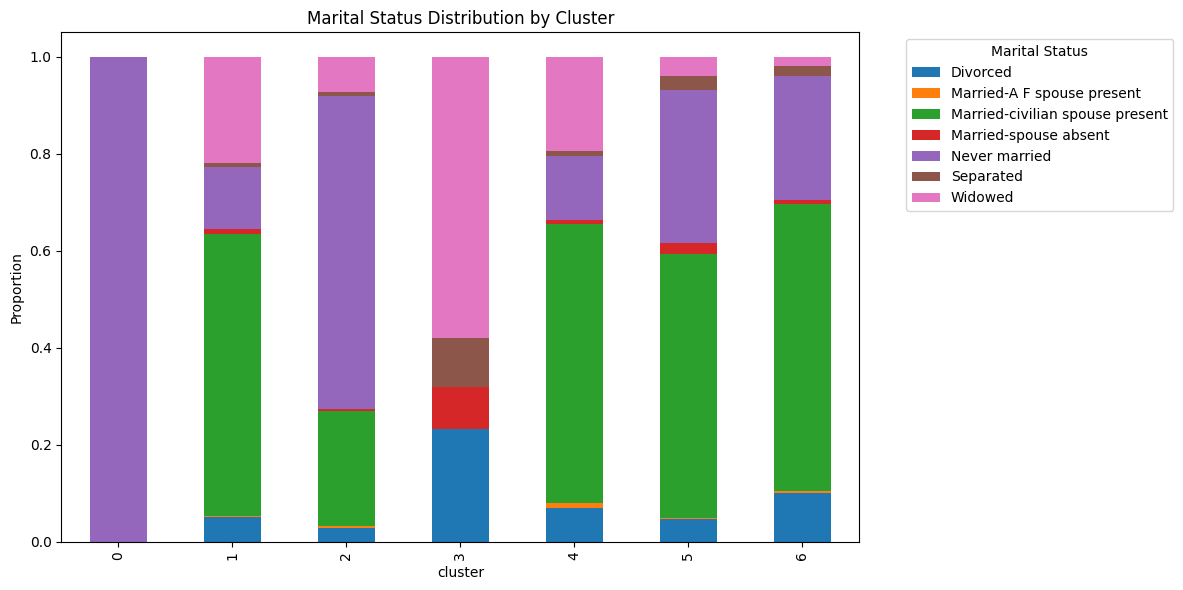

In [ ]:
# Marital Status
mar_dist = pd.crosstab(df['cluster'], df['marital stat'])
mar_dist.div(mar_dist.sum(1), axis=0).plot(kind="bar", stacked=True, figsize=(12,6))

plt.title("Marital Status Distribution by Cluster")
plt.ylabel("Proportion")

# Move legend outside the plot
plt.legend(title='Marital Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # adjust layout so nothing is cut off
plt.show()

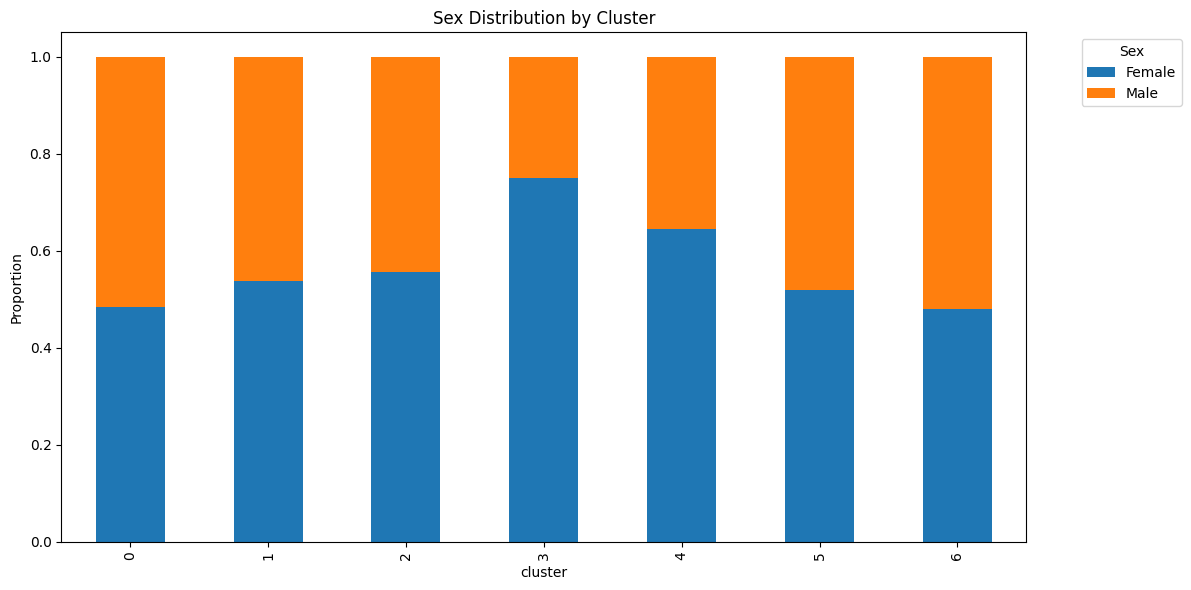

In [ ]:
# Sex
sex_dist = pd.crosstab(df['cluster'], df['sex'])
sex_dist.div(mar_dist.sum(1), axis=0).plot(kind="bar", stacked=True, figsize=(12,6))

plt.title("Sex Distribution by Cluster")
plt.ylabel("Proportion")

# Move legend outside the plot
plt.legend(title='Sex', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # adjust layout so nothing is cut off
plt.show()

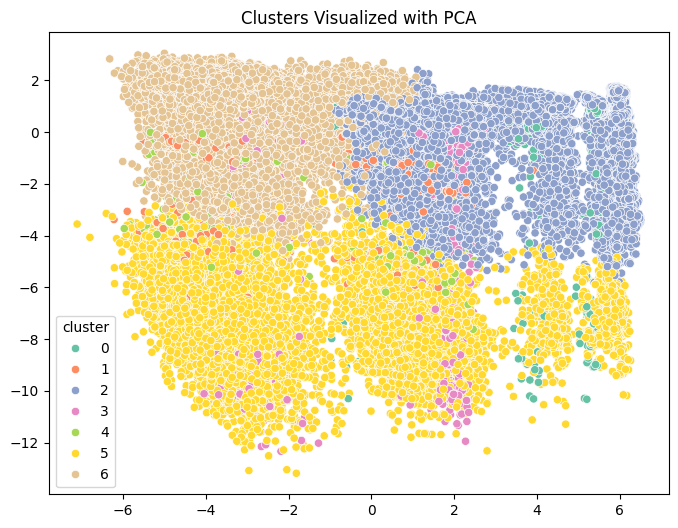

In [ ]:
# 2D illustration
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette="Set2")
plt.title("Clusters Visualized with PCA")
plt.show()

In [ ]:
# Cluster profiling

def cluster_profile(df, cluster_col='cluster', top_n_cat=1):
    """
    Generate cluster profiles for categorical and numerical features.

    Parameters:
        df : pd.DataFrame
            DataFrame with cluster labels assigned.
        cluster_col : str
            Name of the column containing cluster IDs.
        top_n_cat : int
            Number of top categories to show for categorical features.

    Returns:
        profile : dict
            Dictionary of cluster profiles.
    """
    profile = {}
    clusters = df[cluster_col].unique()

    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    if cluster_col in categorical_cols:
        categorical_cols.remove(cluster_col)

    numerical_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    if cluster_col in numerical_cols:
        numerical_cols.remove(cluster_col)

    for c in clusters:
        cluster_df = df[df[cluster_col] == c]
        cluster_info = {}

        # Numerical features: mean
        for col in numerical_cols:
            cluster_info[col] = cluster_df[col].mean()

        # Categorical features: top categories
        for col in categorical_cols:
            top_categories = cluster_df[col].value_counts(normalize=True).head(top_n_cat)
            cluster_info[col] = "; ".join([f"{cat} ({pct:.0%})" for cat, pct in top_categories.items()])

        profile[c] = cluster_info

    profile_df = pd.DataFrame(profile).T  # clusters as rows
    return profile_df

# Usage
profile_table = cluster_profile(df, cluster_col='cluster')
pd.set_option('display.max_columns', None)
print(profile_table)

         age detailed industry recode detailed occupation recode  \
3   65.15615                 8.231016                   7.879144   
6  38.622424                31.158828                  22.344479   
5   38.06973                17.278568                  15.105726   
2  28.520466                 0.090448                   0.084612   
1  62.605516                 9.964029                   7.438249   
4  56.441032                13.476658                     8.4914   
0   9.953688                 2.300172                   2.161235   

  wage per hour capital gains capital losses dividends from stocks  \
3     37.768984     85.630481      34.193048             91.966845   
6    115.778226    792.042222       63.38628            232.404809   
5     49.804836    415.041275      34.499623            100.475089   
2           0.0    103.556638      12.699397            185.477121   
1     31.236811    390.973621      52.914868            313.351918   
4     39.823096    793.528256      